In [99]:
import xarray as xr 
import numpy as np 

import iris
import efp_saffin as saff 
import datetime as dt 

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback/') 
import functions.eddy_feedback as ef 

In [100]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/SPARC_TEM_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds 

<xarray.Dataset>
Dimensions:   (time: 708, pressure: 22, latitude: 73)
Coordinates:
  * time      (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
Data variables:
    ubar      (time, pressure, latitude) float32 dask.array<chunksize=(31, 22, 73), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 dask.array<chunksize=(31, 22, 73), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 dask.array<chunksize=(31, 22, 73), meta=np.ndarray>

In [101]:
# subset to DJF
winter_months = ds.time.dt.month.isin([12,1,2])
djf = ds.sel(time=winter_months)
djf  

<xarray.Dataset>
Dimensions:   (time: 177, pressure: 22, latitude: 73)
Coordinates:
  * time      (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
Data variables:
    ubar      (time, pressure, latitude) float32 dask.array<chunksize=(8, 22, 73), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 dask.array<chunksize=(8, 22, 73), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 dask.array<chunksize=(8, 22, 73), meta=np.ndarray>

In [102]:
# extract ubar and div1 DataArrays
ubar = djf.ubar 
div1 = djf.div1_pr 

# convert xarray to iris cubes
cube_ubar = djf.ubar.to_iris()
cube_div1 = djf.div1_pr.to_iris()


# take a pressure slice to reduce dataset
ubar = ubar.sel(pressure=500.) 
div1 = div1.sel(pressure=500.)

cube_ubar = cube_ubar.extract(iris.Constraint(air_pressure=500.))
cube_div1 = cube_div1.extract(iris.Constraint(air_pressure=500.)) 

### Check values of two different systems

So far, both datasets are equal as expected.

In [103]:
np.testing.assert_allclose(ubar.values, cube_ubar.data)
np.testing.assert_allclose(div1.values, cube_div1.data) 

### Check unchanged averaging methods

In [104]:
ubar = ef.interannual(ubar)
div1 = ef.interannual(div1)

# calculate seasonal mean of cube (needs to be subsetted to DJF already) 
span = dt.timedelta(days=28)
cube_ubar = saff.seasonal_mean(cube_ubar, span)
cube_div1 = saff.seasonal_mean(cube_div1, span) 

THESE HAVE A 100% DIFFERENCE:

In [105]:
# np.testing.assert_allclose(ubar.values, cube_ubar.data)
# np.testing.assert_allclose(div1.values, cube_div1.data) 

# Seasonal means

First we will compare the two different methods, then see if a weighted seasonal average is required.

In [106]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/SPARC_TEM_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

### Take seasonal average

In [107]:
# resample data to start 1st Dec
seasonal = ds.resample(time='QS-DEC').mean('time')

# take winter season of set and cut off last 'season' 
seasonal = seasonal.sel(time=seasonal.time.dt.month.isin([12]))
seasonal = seasonal.where(seasonal.time.dt.year < 2016, drop=True)

seasonal = seasonal.sel(pressure=500.)
seasonal 

<xarray.Dataset>
Dimensions:   (time: 59, latitude: 73)
Coordinates:
    pressure  float32 500.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * time      (time) datetime64[ns] 1957-12-01 1958-12-01 ... 2015-12-01
Data variables:
    ubar      (time, latitude) float32 dask.array<chunksize=(6, 73), meta=np.ndarray>
    div1_pr   (time, latitude) float32 dask.array<chunksize=(6, 73), meta=np.ndarray>
    div1_qg   (time, latitude) float32 dask.array<chunksize=(6, 73), meta=np.ndarray>

In [108]:
# calculate seasonal mean (dataset is already subsetted to DJF)
ubar_seasonal = seasonal.ubar
div1_seasonal = seasonal.div1_pr 


# calculate seasonal mean of cube (needs to be subsetted to DJF already)
span = dt.timedelta(days=28)
cube_ubar = saff.seasonal_mean(cube_ubar, span)
cube_div1 = saff.seasonal_mean(cube_div1, span) 

### Check Seasonal mean differences

- DATA IS PRETTY DAMN CLOSE... (had to reduce tolerance)

- Default tolerance was ~10% accurate

In [110]:
# np.testing.assert_allclose(ubar_seasonal.values, cube_ubar.data)
# np.testing.assert_allclose(div1_seasonal.values, cube_div1.data)

# reduce the tolerance
np.testing.assert_allclose(ubar_seasonal.values, cube_ubar.data, rtol=1e-05)
np.testing.assert_allclose(div1_seasonal.values, cube_div1.data, rtol=1e-04) # 5% mismatch when 1e-05

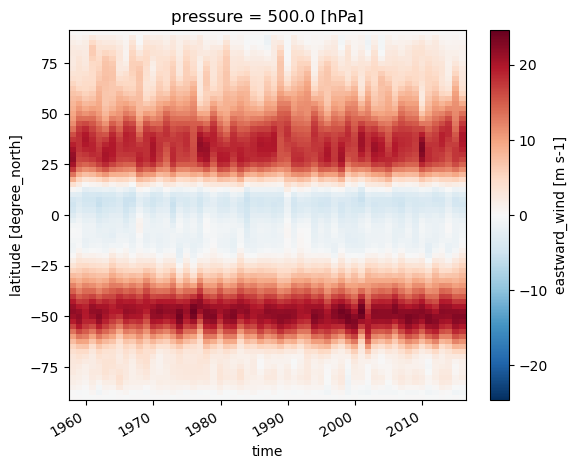

In [ ]:
ubar_seasonal.transpose().plot()

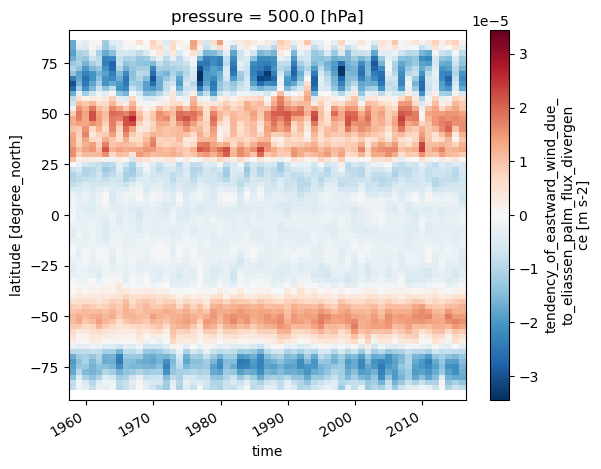

In [ ]:
div1_seasonal.transpose().plot()

## Weighted seasonal means

Difference could also be due to the different labelling of the year of the season.

Inspiration: 
- https://docs.xarray.dev/en/stable/examples/monthly-means.html 
- https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html  

In [ ]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/SPARC_TEM_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

In [ ]:
def seasonal_mean(da, min_month=28):
    
    """
    Input: Xarray DataArray (time, level, lon) 
            - requires statement of minimum number of months 
    
    Output: Xarray DataArray (time, level, lon) 
    
    """
    
    if 'seasonal_year' not in da.dims:
        print('no seasonal_year')
    
    

In [ ]:
days = ds.time.dt.days_in_month
# days

In [ ]:
weights = days.groupby('time.month') / days.groupby('time.month').sum() 
# weights 

# Break Saffin's code

In [ ]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/SPARC_TEM_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds = ds.sel(time=ds.time.dt.month.isin([12,1,2]))
ds 

<xarray.Dataset>
Dimensions:   (time: 177, pressure: 22, latitude: 73)
Coordinates:
  * time      (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
Data variables:
    ubar      (time, pressure, latitude) float32 dask.array<chunksize=(8, 22, 73), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 dask.array<chunksize=(8, 22, 73), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 dask.array<chunksize=(8, 22, 73), meta=np.ndarray>

In [ ]:
# extract ubar and div1 DataArrays
ubar = ds.ubar 
div1 = ds.div1_pr 

# convert xarray to iris cubes
cube_ubar = ds.ubar.to_iris()
cube_div1 = ds.div1_pr.to_iris()


# take a pressure slice to reduce dataset
ubar = ubar.sel(pressure=500.)
div1 = div1.sel(pressure=500.)
cube_ubar = cube_ubar.extract(iris.Constraint(air_pressure=500.))
cube_div1 = cube_div1.extract(iris.Constraint(air_pressure=500.))

In [ ]:
cube = cube_ubar

# Add required time coordinates
if "year" not in [c.name() for c in cube.coords()]:
    iris.coord_categorisation.add_year(cube, 'time') 
    
# Calculate seasonal mean
cube = cube.aggregated_by("year", iris.analysis.MEAN)
cube 

<iris 'Cube' of eastward_wind / (m s-1) (time: 59; latitude: 73)>

In [ ]:
ubar = ubar.groupby('time.year').mean('time')
ubar.values.shape

(59, 73)

In [ ]:
np.testing.assert_allclose(ubar.values, cube.data, rtol=1e-04) 